# SimpleRNN

In [98]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris
import os
import pandas as pd
import numpy as np
import tensorflow.keras as keras
from keras import Model
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from PIL import Image
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 使用 GPU 1
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)
logical_devices = tf.config.list_logical_devices("GPU")

In [6]:
import tushare as ts
os.path.exists('tensorflow_study/chapter6/data_dir')

True

In [9]:
# 数据集下载
df1 = ts.get_k_data('600519', ktype='D', start='2010-04-26', end='2020-04-26')
df1

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,date,open,close,high,low,volume,code
74,2010-04-26,10.801,9.246,11.237,9.223,107036.13,600519
75,2010-04-27,9.216,6.255,9.216,6.068,58234.48,600519
76,2010-04-28,5.542,5.639,6.594,4.790,26287.43,600519
77,2010-04-29,5.962,7.232,7.991,5.962,34501.20,600519
78,2010-04-30,5.113,3.310,5.113,2.349,85566.70,600519
...,...,...,...,...,...,...,...
2495,2020-04-20,1184.682,1190.982,1195.182,1180.482,24239.00,600519
2496,2020-04-21,1184.702,1163.682,1187.672,1156.682,29224.00,600519
2497,2020-04-22,1169.682,1208.182,1213.182,1165.902,44035.00,600519
2498,2020-04-23,1213.682,1215.942,1229.362,1211.452,26899.00,600519


In [10]:
df1.describe()

,open,close,high,low,volume
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000
mean,291.946883,292.556227,296.910919,287.720433,38396.149575
std,325.412907,325.984710,329.261705,322.091195,23905.887219
min,1.034000,1.237000,2.161000,0.658000,7439.110000
25%,63.546000,63.868500,65.812250,61.840000,23364.000000
50%,122.086500,122.196000,125.181000,119.176500,32371.000000
75%,501.893000,503.173750,509.703750,498.213000,46266.250000
max,1213.682000,1215.942000,1229.362000,1211.452000,289140.000000


In [11]:
print(type(df1))

<class 'pandas.core.frame.DataFrame'>


In [14]:
# df1.to_csv('tensorflow_study/chapter6/data_dir/stock.csv')

In [102]:
# 划分train valid
train_set = df1.iloc[:2426-600, 2:3]
test_set = df1.iloc[-600:, 2:3]

In [105]:
# min max 归一化
mm = MinMaxScaler()

train_set_normed = mm.fit_transform(train_set['close'].to_numpy().reshape(-1,1))
test_set_normed = mm.transform(test_set['close'].to_numpy().reshape(-1,1))

# 用训练集进行归一化min max的计算 作用在训练集和测试集上 防止数据泄露

In [108]:
pd.DataFrame(train_set_normed, columns=['close'])

,close
0,0.013575
1,0.008506
2,0.007461
3,0.010162
4,0.003514
...,...
1821,0.949065
1822,0.955692
1823,0.976456
1824,1.000000


In [109]:
# 数据集划分 生成60 -> 1
def sliding_window(df : pd.DataFrame, columns = ['close'], x_len = 60, y_len = 1):
    x_list = list()
    y_list = list()
    row, column = df.shape
    attributes = df[columns]
    target_count = row - x_len - y_len + 1
    for start in range(target_count):
        each_x = attributes.iloc[start: start + x_len] # 左闭右开
        each_y = attributes.iloc[start + x_len]
        x_list.append(each_x.to_numpy().reshape((-1,1))) # [seq_len = 60, feature = 1]
        y_list.append(each_y.to_numpy()) # [feature = 1]
    return np.array(x_list), np.array(y_list)

x_train, y_train = sliding_window(pd.DataFrame(train_set_normed, columns=['close']))
x_test, y_test = sliding_window(pd.DataFrame(test_set_normed, columns=['close']))

In [113]:
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (1766, 60, 1)
y_train.shape:  (1766, 1)
x_test.shape:  (540, 60, 1)
y_test.shape:  (540, 1)


In [114]:
# 模型部分
class LSTMModel(Model):
    def __init__(self, lstm_unit, hidden):
        super(LSTMModel, self).__init__()
        self.hidden = hidden
        self.lstm_unit = lstm_unit

        self.d1 = keras.layers.Dense(units=self.hidden, activation='relu')
        self.lstm = keras.layers.LSTM(units=self.lstm_unit)
        self.d2 = keras.layers.Dense(units=1)

    def call(self, inputs, training=None, mask=None):
        # input [batch, seq_len = 60, feature = 1]
        x = self.d1(inputs)
        # [batch, seq_len = 60, feature = self.hidden]

        x = self.lstm(x)
        # [batch, feature = self.lstm_unit]
        y = self.d2(x)
        return y

In [115]:
lstmModel = LSTMModel(lstm_unit=32, hidden=8)

In [116]:
lstmModel.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MSE,
    metrics=['mse']
)

In [117]:
checkpoint_save_path_lstm = 'tensorflow_study/chapter6/model_dir/lstm_model_{epoch:02d}-{mse:.8f}.ckpt'

cp_callback_lstm = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_save_path_lstm,
    save_weights_only=True,
    save_best_only=True,
    monitor='mse',
)

In [118]:
history_lstm = lstmModel.fit(x_train, y_train, batch_size=64, epochs=500, validation_data=(x_test, y_test),  validation_freq=20, callbacks=[cp_callback_lstm])

Epoch 1/500
28/28 [==============================] - 1s 9ms/step - loss: 0.0297 - mse: 0.0297
Epoch 2/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0024 - mse: 0.0024
Epoch 3/500
28/28 [==============================] - 0s 10ms/step - loss: 5.2056e-04 - mse: 5.2056e-04
Epoch 4/500
28/28 [==============================] - 0s 10ms/step - loss: 3.1743e-04 - mse: 3.1743e-04
Epoch 5/500
28/28 [==============================] - 0s 10ms/step - loss: 2.5947e-04 - mse: 2.5947e-04
Epoch 6/500
28/28 [==============================] - 0s 10ms/step - loss: 2.2745e-04 - mse: 2.2745e-04
Epoch 7/500
28/28 [==============================] - 0s 9ms/step - loss: 1.9789e-04 - mse: 1.9789e-04
Epoch 8/500
28/28 [==============================] - 0s 9ms/step - loss: 1.8500e-04 - mse: 1.8500e-04
Epoch 9/500
28/28 [==============================] - 0s 9ms/step - loss: 1.7834e-04 - mse: 1.7834e-04
Epoch 10/500
28/28 [==============================] - 0s 9ms/step - loss: 1.7566e-04 - mse: 1.

In [119]:
lstmModel.summary()

Model: "lstm_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  16        
                                                                 
 lstm_2 (LSTM)               multiple                  5248      
                                                                 
 dense_5 (Dense)             multiple                  33        
                                                                 
Total params: 5,297
Trainable params: 5,297
Non-trainable params: 0
_________________________________________________________________


In [120]:
history_lstm.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

In [122]:
mse_lstm = history_lstm.history['mse']
val_mse_lstm = history_lstm.history['val_mse']
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

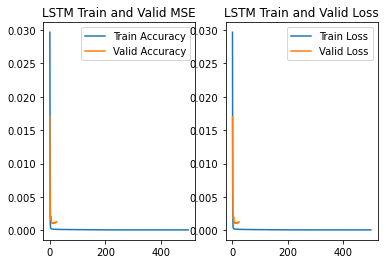

In [123]:
plt.subplot(1,2,1)
plt.plot(mse_lstm, label = 'Train Accuracy')
plt.plot(val_mse_lstm, label = 'Valid Accuracy')
plt.title('LSTM Train and Valid MSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_lstm, label = 'Train Loss')
plt.plot(val_loss_lstm, label = 'Valid Loss')
plt.title('LSTM Train and Valid Loss')
plt.legend()
plt.show()